# REINFORCE in pytorch

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


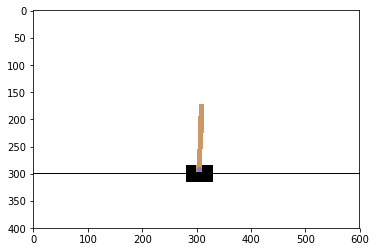

In [3]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

У нас есть два действия. Почему мы не будем использовать софтмакс?
Потому что мы всё равно будем брать логарифм. В нашей оценке фигурирует производная логарифма вероятности.

$\pi(a_0|s) = logit_0 - log(e^{logit_0} + e^{logit_1})$

В терминах pytorch последнее - F.log_softmax

In [6]:
# Build a simple neural network that predicts policy logits. Keep it simple: CartPole isn't worth deep architectures.
agent = nn.Sequential(nn.Linear(state_dim[0], 100),
                      nn.ReLU(),
                      nn.Linear(100, n_actions)
                     )

# < YOUR CODE HERE: define a neural network that predicts policy logits >

In [11]:
ss = Variable(torch.FloatTensor(env.reset().reshape([1,4])))

agent(ss)

Variable containing:
1.00000e-02 *
  6.7289  5.2992
[torch.FloatTensor of size 1x2]

Получили два логита, вероятности:

In [12]:
F.softmax(agent(ss))

/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


Variable containing:
 0.5036  0.4964
[torch.FloatTensor of size 1x2]

In [14]:
F.log_softmax(agent(ss))

/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


Variable containing:
-0.6860 -0.7003
[torch.FloatTensor of size 1x2]

#### Predict function

In [28]:
use_cuda = True

In [29]:
if use_cuda and torch.cuda.is_available():
    from torch.cuda import FloatTensor
else:
    from torch import FloatTensor

In [36]:
def predict_proba(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    states = Variable(torch.FloatTensor(states))
    
    return F.softmax(agent(states)).cpu().data.numpy()

In [33]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
assert isinstance(test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], n_actions), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis = 1), 1), "probabilities do not sum to 1"

/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


### Play the game

We can now use our newly built agent to play the game.

In [50]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = predict_proba(np.array([s]))[0] 
        
        a = np.random.choice(n_actions, p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    return states, actions, rewards

In [51]:
# test it
states, actions, rewards = generate_session()

/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


### Computing cumulative rewards

In [61]:
# i.e G
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cum_rews = []
    
    prev_reward = 0
    for reward in rewards[::-1]:
        cum_rew = reward + prev_reward * gamma
        cum_rews.append(cum_rew)
        prev_reward = cum_rew
        
    return np.array(cum_rews[::-1])

In [62]:
get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9)

array([1.40049, 1.5561 , 1.729  , 0.81   , 0.9    , 1.     , 0.     ])

In [63]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [64]:
def to_one_hot(y, n_dims=None):
    """ Take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [67]:
# Your code: define optimizers
opt = torch.optim.Adam(agent.parameters())
def train_on_session(states, actions, rewards, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into a variable
    states = Variable(torch.FloatTensor(states))
    actions = Variable(torch.IntTensor(actions))
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = Variable(torch.FloatTensor(cumulative_returns))
    
    # predict logits, probas and log-probas using an agent. 
    logits = agent(states)
    probas = F.softmax(logits)
    logprobas = F.log_softmax(logits)
    
    assert all(isinstance(v, Variable) for v in [logits, probas, logprobas]), \
        "please use compute using torch tensors and don't use predict_proba function"
    
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    # only for those actions that agent actually did.
    # We only influence probability of given action in a given state.
    logprobas_for_actions = torch.sum(logprobas * to_one_hot(actions), dim = 1)
    
    # REINFORCE objective function
    # we dont want our gradient to depend on the length of the game
    J_hat = torch.mean(logprobas_for_actions * cumulative_returns)
    
    #regularize with entropy
    #it is not a binary log, but just a coef so whatever
    entropy_reg = - (probas * logprobas).sum(-1).mean()
    
    loss = - J_hat - 0.1 * entropy_reg
    
    # Gradient descent step
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # technical: return session rewards to print them later
    return np.sum(rewards)


### The actual training

In [68]:
for i in range(100):
    
    rewards = [train_on_session(*generate_session()) for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 500:
        print ("You Win!") # but you can train even further
        break
        


/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


mean reward:23.110
mean reward:32.230
mean reward:50.470
mean reward:63.980
mean reward:109.150
mean reward:108.990
mean reward:156.370
mean reward:150.740
mean reward:261.870
mean reward:290.720
mean reward:173.780
mean reward:404.080
mean reward:427.050
mean reward:239.520
mean reward:520.310
You Win!


Qlearning wasn't improving score in the beginning, because it was learning a lot of things in the beginning

Now we optimize straight from the beginning and everybody is happy

### Video

In [69]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/home/igolovanov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sy

In [70]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices